# Dataset Creation

In [33]:
#Clear previously stored variables
%reset -f

## 1. Imports

In [34]:
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib

## 2. Creating Lists of Image Paths and MGMT Labels


### 2.1 Glob Function

In [35]:
#taken from Ashley's classifier, not needed atm

import glob # for loading the data
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

### 2.2 Dataset - Ivy Foundation


#### 2.2.1 Loading Labels from Excel


In [36]:
ivy_data = pd.read_excel('/trials/Ivy_Foundation/Document_final/Ivy_OS_Data_September2018_JEG_edits.xlsx')
ivy_data = ivy_data[['ID', 'MGMT']]

ivy_labels = {}

for i in ivy_data.index:
    if (ivy_data['MGMT'][i] == "Methylated"):
        ivy_labels[ivy_data['ID'][i]] = 1
    elif (ivy_data['MGMT'][i] == "Unmethylated"):
        ivy_labels[ivy_data['ID'][i]] = 0


#### 2.2.2 Adding Labels and Image Path to Lists

In [37]:
ivy_root = '/trials/Ivy_Foundation/Final_for_Distribution'
ivy_t1c = []
ivy_t2 = []
ivy_mask = []
ivy_mgmt = []

#Pre
for key in ivy_labels.keys():
    t1c_path = ivy_root + '/Pre/' + "{:05d}".format(key) + '/NIFTI_Native/t1+c.nii.gz'
    t2_path = ivy_root + '/Pre/' + "{:05d}".format(key) + '/NIFTI_Native/t2.nii.gz'
    mask_path = ivy_root + '/Pre/' + "{:05d}".format(key) + '/NIFTI_Native/FlairMask.nii.gz'
    
    if (os.path.isfile(t1c_path)) and (os.path.isfile(t2_path)) and os.path.isfile(mask_path):
        ivy_t1c.append(t1c_path)
        ivy_t2.append(t2_path)
        ivy_mask.append(mask_path)
        ivy_mgmt.append(ivy_labels[key])

#Post
for key in ivy_labels.keys():
    t1c_path = ivy_root + '/Post/' + "{:05d}".format(key) + '/NIFTI_Native/t1+c.nii.gz'
    t2_path = ivy_root + '/Post/' + "{:05d}".format(key) + '/NIFTI_Native/t2.nii.gz'
    mask_path = ivy_root + '/Post/' + "{:05d}".format(key) + '/NIFTI_Native/FlairMask.nii.gz'
    
    if (os.path.isfile(t1c_path)) and (os.path.isfile(t2_path)) and os.path.isfile(mask_path):
        ivy_t1c.append(t1c_path)
        ivy_t2.append(t2_path)
        ivy_mask.append(mask_path)
        ivy_mgmt.append(ivy_labels[key])

print(len(ivy_t1c))

assert(len(ivy_t1c) == len(ivy_mgmt))
assert(len(ivy_mgmt) == len(ivy_mask))

597


### 2.3 Dataset - Atlas Concatenated

#### 2.3.1 Loading Labels from Excel


In [38]:
atlas_data = pd.read_excel('/trials/AVAglio/Analysis/labels.xlsx', header=1, sheet_name="VOLUMES")
atlas_data = atlas_data[['PT', 'S_MGMT']]
PT_conversion = pd.read_excel('/trials/AVAglio/Analysis/labels.xlsx', header=1, sheet_name="Sheet2")
PT_conversion = PT_conversion[['ID','PT']]

conversion_table = {}
atlas_labels = {}

for i in PT_conversion.index:
    conversion_table[PT_conversion['PT'][i]] = PT_conversion['ID'][i]

for i in atlas_data.index:
    IDnum = conversion_table.get(atlas_data['PT'][i], -1)
    exists = (IDnum != -1)
    if (atlas_data['S_MGMT'][i] == 1) and exists:
        atlas_labels[IDnum] = 1
    elif (atlas_data['S_MGMT'][i] == 0) and exists:
        atlas_labels[IDnum] = 0

print(len(atlas_labels))

603


#### 2.3.2 Adding Labels and Image Paths to List


In [39]:
atlas_root = '/trials/AVAglio/DATA/Review'
atlas_t1c = []
atlas_t2 = []
atlas_mask = []
atlas_mgmt = []
error_counter = 0

for key in atlas_labels.keys():
    t1c_path = atlas_root + '/*-' + "{:04d}".format(key) + '/data/1/t1+c.nii.gz'
    t2_path = atlas_root + '/*-' + "{:04d}".format(key) + '/data/1/t2.nii.gz'
    mask_path = atlas_root + '/*-' + "{:04d}".format(key) + '/data/1/mask.deltat1.nii.gz'

    t1c_path = insensitive_glob(t1c_path)
    t2_path = insensitive_glob(t2_path)
    mask_path = insensitive_glob(mask_path)
    
    if len(t1c_path) < 1:
        t1c_path = insensitive_glob(atlas_root + '/*-' + "{:04d}".format(key) + '/data/1/*/NIFTI_Native/t1+c.nii.gz')
    if len(t2_path) < 1:
        t2_path = insensitive_glob(atlas_root + '/*-' + "{:04d}".format(key) + '/data/1/*/NIFTI_Native/t2.nii.gz')
    if len(mask_path) < 1:
        mask_path = insensitive_glob(atlas_root + '/*-' + "{:04d}".format(key) + '/data/1/*/NIFTI_Native/mask.deltat1.nii.gz')

    
    try:
        if (os.path.isfile(t1c_path[0])) and (os.path.isfile(t2_path[0])) and os.path.isfile(mask_path[0]):
            atlas_t1c.append(t1c_path[0])
            atlas_t2.append(t2_path[0])
            atlas_mask.append(mask_path[0])
            atlas_mgmt.append(atlas_labels[key])
    except:
        error_counter += 1

print('Valid Data from Atlas: ')
print(len(atlas_t1c))
print()
print('Errors from Atlas')
print(error_counter)

assert(len(atlas_t1c) == len(atlas_mgmt))
assert(len(atlas_mgmt) == len(atlas_t2))

Valid Data from Atlas: 
461

Errors from Atlas
142


## 3. Create Data Dictionaries

In [46]:
dataset_ivy = pd.DataFrame(np.column_stack([ivy_t1c, ivy_t2, ivy_mask, ivy_mgmt]), columns=['t1c', 't2', 'tmask', 'MGMT'])
dataset_atlas = pd.DataFrame(np.column_stack([atlas_t1c, atlas_t2, atlas_mask, atlas_mgmt]), columns=['t1c', 't2', 'tmask', 'MGMT'])

dataset_all = result = pd.concat([dataset_ivy, dataset_atlas])
print("Initial list  size  All - "  + str(dataset_all.shape))
dataset_all.head()

Initial list  size  All - (1058, 4)


,t1c,t2,tmask,MGMT
0,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,0
1,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,1
2,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,1
3,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,0
4,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,1


## 4. Check Dataset

### 4.1 Dataset Distribution

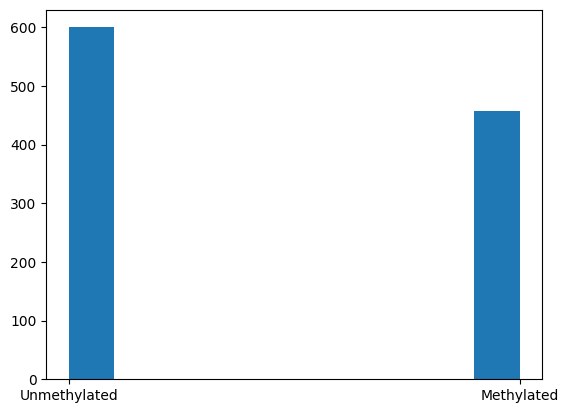

In [47]:
import matplotlib.pyplot as plt

bins = [0,1]
classes = ["Unmethylated", "Methylated"]
plt.hist(dataset_all["MGMT"])
plt.xticks(bins, labels=classes)
plt.show()

## 5. Shuffle and Split Dataset

### 5.1 Shuffle the Dataset


In [48]:
# Shuffle dataframe and reset indices
dataset_all = dataset_all.sample(frac=1, random_state=3)
dataset_all = dataset_all.reset_index(drop=True)
dataset_all.head()

,t1c,t2,tmask,MGMT
0,/trials/AVAglio/DATA/Review/200190-2915/data/1...,/trials/AVAglio/DATA/Review/200190-2915/data/1...,/trials/AVAglio/DATA/Review/200190-2915/data/1...,1
1,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,1
2,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,1
3,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,1
4,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,/trials/Ivy_Foundation/Final_for_Distribution/...,0


### 5.2 Train/Valid/Test Split

In [49]:
train_size = int(dataset_all.shape[0] * 0.8)
valid_size = int(dataset_all.shape[0] * 0.1)
test_size = int(dataset_all.shape[0] * 0.1)

print(train_size, valid_size, test_size)

dictionary_train = [
    {"t1c": a, "t2": b, "tmask": c, "MGMT": d}
    for a, b, c, d in zip(dataset_all[:train_size].t1c, dataset_all[:train_size].t2, dataset_all[:train_size].tmask, dataset_all[:train_size].MGMT)
]

dictionary_valid = [
    {"t1c": a, "t2": b, "tmask": c, "MGMT": d}
    for a, b, c, d in zip(dataset_all[train_size:train_size+valid_size].t1c, dataset_all[train_size:train_size+valid_size].t2, dataset_all[train_size:train_size+valid_size].tmask, dataset_all[train_size:train_size+valid_size].MGMT)
]

dictionary_test = [
    {"t1c": a, "t2": b, "tmask": c, "MGMT": d}
    for a, b, c, d in zip(dataset_all[-test_size:].t1c, dataset_all[-test_size:].t2, dataset_all[-test_size:].tmask, dataset_all[-test_size:].MGMT)
]

print(len(dictionary_train), len(dictionary_valid), len(dictionary_test))

846 105 105
846 105 105


### 5.3 Visualize Distribution of Each Split

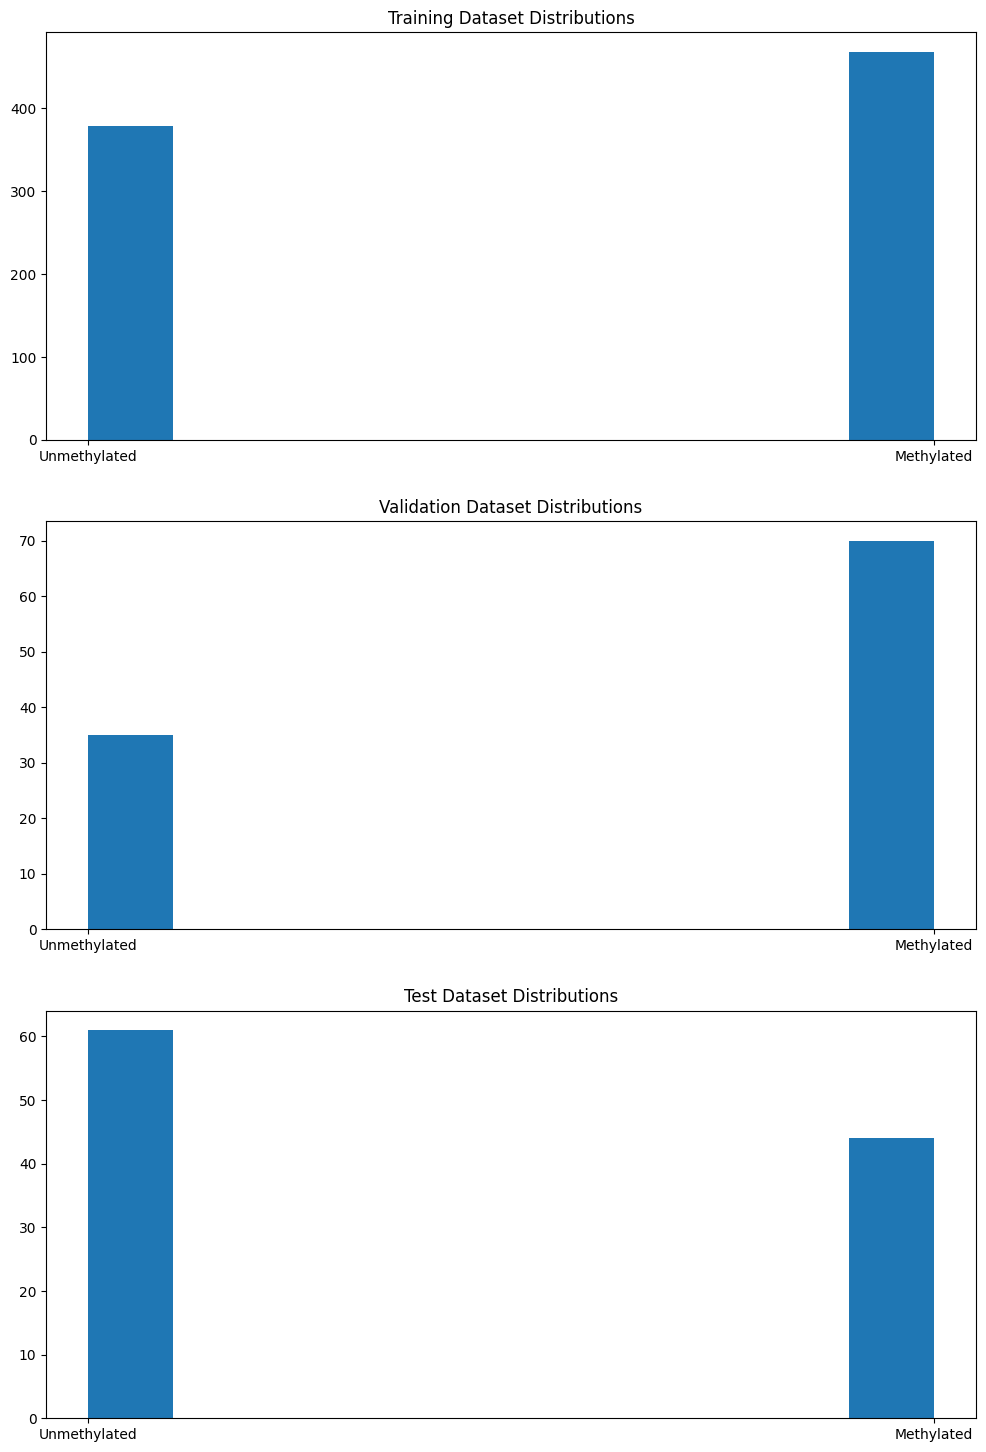

{'t1c': '/trials/AVAglio/DATA/Review/200194-2171/data/1/20101028/NIFTI_Native/t1+c.nii.gz', 't2': '/trials/AVAglio/DATA/Review/200194-2171/data/1/20101028/NIFTI_Native/t2.nii.gz', 'tmask': '/trials/AVAglio/DATA/Review/200194-2171/data/1/20101028/NIFTI_Native/mask.deltat1.nii.gz', 'MGMT': '1'}
{'t1c': '/trials/Ivy_Foundation/Final_for_Distribution/Post/01168/NIFTI_Native/t1+c.nii.gz', 't2': '/trials/Ivy_Foundation/Final_for_Distribution/Post/01168/NIFTI_Native/t2.nii.gz', 'tmask': '/trials/Ivy_Foundation/Final_for_Distribution/Post/01168/NIFTI_Native/FlairMask.nii.gz', 'MGMT': '1'}
{'t1c': '/trials/AVAglio/DATA/Review/200373-3853/data/1/t1+c.nii.gz', 't2': '/trials/AVAglio/DATA/Review/200373-3853/data/1/t2.nii.gz', 'tmask': '/trials/AVAglio/DATA/Review/200373-3853/data/1/mask.deltat1.nii.gz', 'MGMT': '1'}
{'t1c': '/trials/AVAglio/DATA/Review/200394-2406/data/1/20101203/NIFTI_Native/t1+c.nii.gz', 't2': '/trials/AVAglio/DATA/Review/200394-2406/data/1/20101203/NIFTI_Native/t2.nii.gz', 'tma

In [50]:
bins = [0, 1]
mgmt_status = ["Unmethylated", "Methylated"]


plt.figure("distributions", (12,18))

plt.subplot(3, 1, 1)
plt.title("Training Dataset Distributions")
plt.hist(dataset_all[:train_size].MGMT)
plt.xticks(bins, labels=mgmt_status)

plt.subplot(3, 1, 2)
plt.title("Validation Dataset Distributions")
plt.hist(dataset_all[train_size:train_size+valid_size].MGMT)
plt.xticks(bins, labels=mgmt_status)

plt.subplot(3, 1, 3)
plt.title("Test Dataset Distributions")
plt.hist(dataset_all[-test_size:].MGMT)
plt.xticks(bins, labels=mgmt_status)

plt.show()

for i in range(5):
    print(dictionary_valid[i])

## 6. Store Datasets

In [51]:
%store dictionary_train
%store dictionary_valid
%store dictionary_test

Stored 'dictionary_train' (list)
Stored 'dictionary_valid' (list)
Stored 'dictionary_test' (list)
